In [1]:
%matplotlib inline

import os, sys, gc
from tqdm import tqdm, tqdm_notebook, tqdm_pandas
from tqdm import trange
import time
from scipy import stats
from scipy.stats import shapiro

import pandas as pd
import numpy as np
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

from Bio import SeqIO
from collections import Counter

from multiprocessing import Pool, Process

import itertools
from modules.kidera import score_positions, score_sequence

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import roc_curve, auc

from joblib import dump, load

import warnings
warnings.filterwarnings('ignore')

In [28]:
aa =   ['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y']
ignore = ["*", "U", "X"]
viruses = ['CMV_StrainAD169', 'YFV_Strain17D', 'HIV-1_StrainHXB2', 'HCV_StrainIsolateH', 'EBV_StrainAG876']
bacteria = ['SHGLsonnei', 'SLMLenteritidis', 'MYPLpneumoniae', 'MYBTsmegmatis', 'SLMLtyphimurium', 
            'YERSpseudotuberculosis', 'YERSenterocolitica', 'CLMDtrachomatis', 'MYPLsynoviae', 'KLEBpneumoniae',
            'CPBTjejuni', 'SHGLflexneri', 'CLOSdificile']
kidera = ["helix.bend.pref", "side.chain.size",
           "extended.str.pref", "hydrophobicity", "double.bend.pref", "partial.spec.vol",
           "flat.ext.pref", "occurrence.alpha.reg", "pK.C", "surrounding.hydrop"]

In [3]:
fdict = {}
for key in os.listdir("data/fasta/"):
    if key.startswith("UP0"):
        fdict[key] = "Human"
    else:
        fdict[key] = key.strip("strain.fasta").strip("_")
fdict

{'CLMDtrachomatis_strain.fasta': 'CLMDtrachomatis',
 'CLOSdificile_strain.fasta': 'CLOSdificile',
 'CMV_StrainAD169.fasta': 'CMV_StrainAD169',
 'CPBTjejuni_strain.fasta': 'CPBTjejuni',
 'EBV_StrainAG876.fasta': 'EBV_StrainAG876',
 'HCV_StrainIsolateH.fasta': 'HCV_StrainIsolateH',
 'HIV-1_StrainHXB2.fasta': 'HIV-1_StrainHXB2',
 'KLEBpneumoniae_strain.fasta': 'KLEBpneumoniae',
 'MYBTsmegmatis_strain.fasta': 'MYBTsmegmatis',
 'MYPLpneumoniae_strain.fasta': 'MYPLpneumoniae',
 'MYPLsynoviae_strain.fasta': 'MYPLsynoviae',
 'SHGLflexneri_strain.fasta': 'SHGLflexneri',
 'SHGLsonnei_strain.fasta': 'SHGLsonnei',
 'SLMLenteritidis_strain.fasta': 'SLMLenteritidis',
 'SLMLtyphimurium_strain.fasta': 'SLMLtyphimurium',
 'UP000005640_9606.fasta': 'Human',
 'YERSenterocolitica_strain.fasta': 'YERSenterocolitica',
 'YERSpseudotuberculosis_strain.fasta': 'YERSpseudotuberculosis',
 'YFV_Strain17D.fasta': 'YFV_Strain17D'}

In [86]:
def aa_prot_count(args):
    path, species = args
    record_dict = SeqIO.index("data/fasta/" + path, "fasta")
    df = pd.DataFrame(columns=['species', 'protein']+aa)
    aa_dict  = Counter()
    for key in record_dict.keys():
        aa_dict = aa_dict + Counter(record_dict[key].seq)
        for amino in list(aa_dict):
            if amino in ignore:
                del aa_dict[amino]
        df1 = pd.DataFrame.from_dict(aa_dict, orient='index').T / sum(aa_dict.values())
        df1['species'] = species
        df1['protein'] = key
        df = pd.concat([df, df1])
    return df
    
with Pool(processes=len(fdict)) as pool:
    result = tqdm_notebook(pool.map(aa_prot_count, fdict.items()))

df = pd.concat(result, axis=0)
df = df.fillna(0)
df = df.reset_index(drop=True)

In [132]:
df.head()

,A,C,D,E,F,G,H,I,K,L,...,P,Q,R,S,T,V,W,Y,protein,species
0,0.097595,0.042433,0.060820,0.056577,0.029703,0.065064,0.036775,0.024045,0.019802,0.097595,...,0.045262,0.031117,0.099010,0.083451,0.059406,0.072136,0.008487,0.025460,sp|P16788|UL97_HCMVA,CMV_StrainAD169
1,0.093590,0.041026,0.058974,0.052564,0.034615,0.065385,0.034615,0.025641,0.021795,0.100000,...,0.047436,0.029487,0.101282,0.084615,0.057692,0.071795,0.008974,0.023077,sp|P16777|UL12_HCMVA,CMV_StrainAD169
2,0.081778,0.051556,0.059556,0.050667,0.034667,0.071111,0.033778,0.030222,0.026667,0.098667,...,0.048889,0.030222,0.088000,0.078222,0.058667,0.071111,0.011556,0.027556,sp|P16800|CEP2_HCMVA,CMV_StrainAD169
3,0.080792,0.038523,0.066346,0.049759,0.029963,0.067416,0.042804,0.027287,0.026752,0.093098,...,0.067951,0.040663,0.084002,0.080792,0.058320,0.059390,0.008561,0.028892,sp|P16749|ICP27_HCMVA,CMV_StrainAD169
4,0.080864,0.036665,0.064289,0.050226,0.029131,0.065796,0.040683,0.030136,0.027122,0.091914,...,0.066801,0.041185,0.081366,0.079859,0.062280,0.059267,0.009543,0.031140,sp|P16744|UL08_HCMVA,CMV_StrainAD169


In [24]:
def group_name(name):
    if name in viruses:
        return 'virus'
    elif name in bacteria:
        return 'bacterium'
    elif name in 'Human':
        return 'human'

pca = PCA(n_components=2)

pctd = pca.fit_transform(df[aa])
pcdf = pd.DataFrame(data = pctd, columns = ['pc1', 'pc2'])
pcdf['species'] = df.species

pcdf.species = pcdf.species.apply(lambda x: group_name(x))
pcdf.head()

,pc1,pc2,species
0,0.042277,0.036992,virus
1,0.039020,0.036611,virus
2,0.027458,0.034568,virus
3,0.026096,0.046994,virus
4,0.023504,0.043325,virus


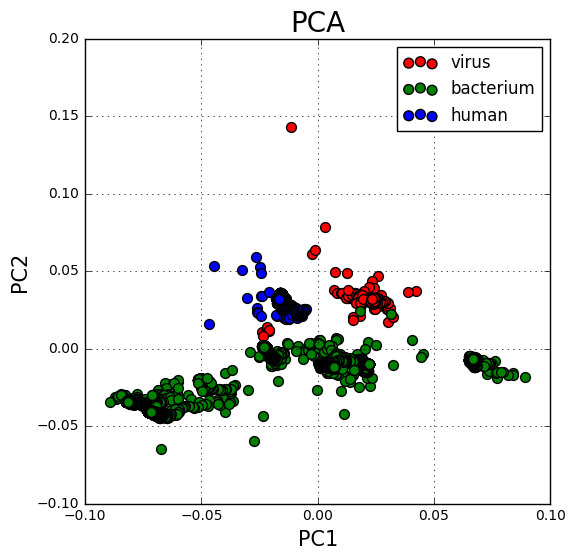

In [26]:
fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('PC1', fontsize = 15)
ax.set_ylabel('PC2', fontsize = 15)
ax.set_title('PCA', fontsize = 20)

targets = pcdf.species.unique()
colours = ['r', 'g', 'b']
for target, colour in zip(targets,colours):
    indicesToKeep = pcdf['species'] == target
    ax.scatter(pcdf.loc[indicesToKeep, 'pc1']
               , pcdf.loc[indicesToKeep, 'pc2']
               , c = colour
               , s = 50)
ax.legend(targets)
ax.grid()

In [27]:
df.shape

(70067, 22)

In [75]:
def aa_kidera(args):
    path, species = args
    record_dict = SeqIO.index("data/fasta/" + path, "fasta")
    df = pd.DataFrame(columns=['species', 'protein']+kidera)
    for key in record_dict.keys():
        d = score_sequence(record_dict[key].seq, norm=True)
        df1 = pd.DataFrame(d).T
        df1.columns = kidera
        df1['species'] = species
        df1['protein'] = key
        df = pd.concat([df, df1])
    return df
    
with Pool(processes=len(fdict)) as pool:
    result = pool.map(aa_kidera, fdict.items())

kdf = pd.concat(result, axis=0)

In [76]:
kdf = kdf.reset_index(drop=True)
kdf.head()

,double.bend.pref,extended.str.pref,flat.ext.pref,helix.bend.pref,hydrophobicity,occurrence.alpha.reg,pK.C,partial.spec.vol,protein,side.chain.size,species,surrounding.hydrop
0,-0.254470,0.036124,-0.008416,-0.087765,0.110863,-0.120184,0.009434,-0.173989,sp|P16788|UL97_HCMVA,-0.276591,CMV_StrainAD169,0.196337
1,-0.183836,0.127123,0.118082,0.038767,0.008493,-0.136986,0.084110,-0.332877,sp|P16777|UL12_HCMVA,-0.154658,CMV_StrainAD169,0.136712
2,-0.131913,0.060667,0.090986,0.009333,-0.030928,-0.061536,-0.002058,-0.108986,sp|P16800|CEP2_HCMVA,-0.253826,CMV_StrainAD169,0.202580
3,-0.073401,-0.115282,-0.065806,0.081250,0.154704,-0.212164,0.058737,-0.173266,sp|P16749|ICP27_HCMVA,-0.231734,CMV_StrainAD169,0.104207
4,-0.132131,0.164098,-0.048689,-0.002377,0.095410,-0.103689,-0.057705,-0.216967,sp|P16744|UL08_HCMVA,-0.187459,CMV_StrainAD169,-0.177951


In [77]:
def group_name(name):
    if name in viruses:
        return 'virus'
    elif name in bacteria:
        return 'bacterium'
    elif name in 'Human':
        return 'human'

pca = PCA(n_components=2)

pctd = pca.fit_transform(kdf[kidera])
pcdf = pd.DataFrame(data = pctd, columns = ['pc1', 'pc2'])
pcdf['species'] = kdf['species']
pcdf.species = pcdf.species.apply(lambda x: group_name(x))
pcdf.head()

,pc1,pc2,species
0,0.055257,0.168783,virus
1,-0.011615,0.053773,virus
2,-0.015979,0.164156,virus
3,0.201985,0.221497,virus
4,0.043632,-0.004502,virus


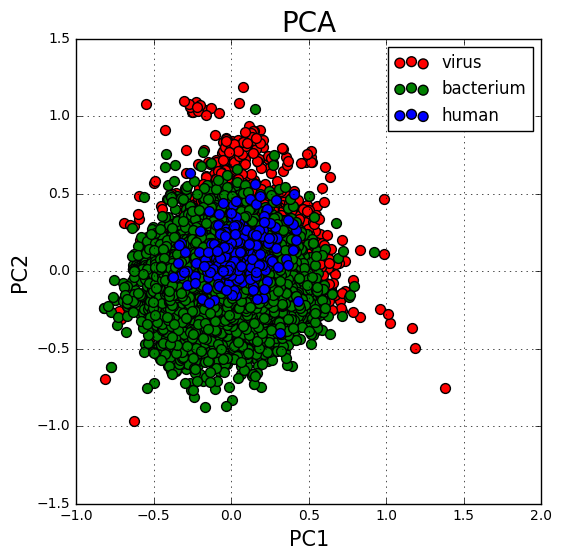

In [78]:
fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('PC1', fontsize = 15)
ax.set_ylabel('PC2', fontsize = 15)
ax.set_title('PCA', fontsize = 20)

targets = pcdf.species.unique()
colours = ['r', 'g', 'b']
for target, colour in zip(targets[::-1],colours):
    indicesToKeep = pcdf['species'] == target
    ax.scatter(pcdf.loc[indicesToKeep, 'pc1']
               , pcdf.loc[indicesToKeep, 'pc2']
               , c = colour
               , s = 50)
ax.legend(targets)
ax.grid()

In [79]:
kdf.species = kdf.species.apply(lambda x: group_name(x))

In [80]:
kdf.groupby('species')['hydrophobicity'].median()

species
bacterium    0.072684
human        0.093024
virus        0.051103
Name: hydrophobicity, dtype: float64

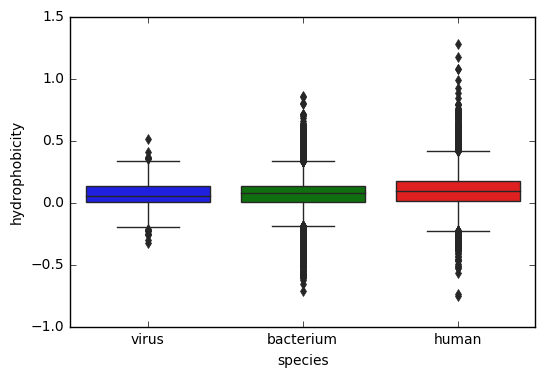

In [81]:
sns.boxplot(x='species', y='hydrophobicity', data=kdf)

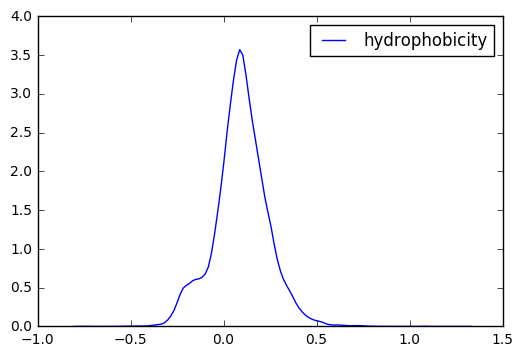

In [82]:
sns.kdeplot(kdf[kdf['species']=='human']['hydrophobicity'])

In [101]:
fdf = df.copy()
fdf.species = fdf.species.apply(lambda x: group_name(x))
di = {'virus': 0, 'bacterium': 0, 'human': 1}
fdf.replace({'species': di}, inplace=True)
fdf[['species', 'protein']].head()

,species,protein
0,0,sp|P16788|UL97_HCMVA
1,0,sp|P16777|UL12_HCMVA
2,0,sp|P16800|CEP2_HCMVA
3,0,sp|P16749|ICP27_HCMVA
4,0,sp|P16744|UL08_HCMVA


In [89]:
fdf.head()

,A,C,D,E,F,G,H,I,K,L,...,P,Q,R,S,T,V,W,Y,protein,species
0,0.097595,0.042433,0.060820,0.056577,0.029703,0.065064,0.036775,0.024045,0.019802,0.097595,...,0.045262,0.031117,0.099010,0.083451,0.059406,0.072136,0.008487,0.025460,sp|P16788|UL97_HCMVA,non-human
1,0.093590,0.041026,0.058974,0.052564,0.034615,0.065385,0.034615,0.025641,0.021795,0.100000,...,0.047436,0.029487,0.101282,0.084615,0.057692,0.071795,0.008974,0.023077,sp|P16777|UL12_HCMVA,non-human
2,0.081778,0.051556,0.059556,0.050667,0.034667,0.071111,0.033778,0.030222,0.026667,0.098667,...,0.048889,0.030222,0.088000,0.078222,0.058667,0.071111,0.011556,0.027556,sp|P16800|CEP2_HCMVA,non-human
3,0.080792,0.038523,0.066346,0.049759,0.029963,0.067416,0.042804,0.027287,0.026752,0.093098,...,0.067951,0.040663,0.084002,0.080792,0.058320,0.059390,0.008561,0.028892,sp|P16749|ICP27_HCMVA,non-human
4,0.080864,0.036665,0.064289,0.050226,0.029131,0.065796,0.040683,0.030136,0.027122,0.091914,...,0.066801,0.041185,0.081366,0.079859,0.062280,0.059267,0.009543,0.031140,sp|P16744|UL08_HCMVA,non-human


In [129]:
from sklearn import svm
from sklearn.model_selection import cross_val_score, cross_validate

clf = svm.SVC()

X_train, X_test, y_train, y_test = train_test_split(fdf[aa].values, fdf['species'].values, test_size=.25)

scores = cross_val_score(clf, X=X_train, y=y_train, cv=5)
np.mean(scores)

0.99607994377097486

In [133]:
scores

array([ 0.99590905,  0.99590905,  0.99571836,  0.99666952,  0.99619374])